## 

## Structural Analysis 

In [45]:
import os 
import pandas as pd 
import numpy as np 
import re
import plotly.express as px
from tqdm import tqdm
import json 
import shutil
import scipy
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr
from scipy.stats import t
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.spatial import ConvexHull

from Bio.PDB import MMCIFParser, Superimposer
import numpy as np
from scipy.spatial.distance import cdist
import plotly.express as px
from Bio.PDB import is_aa
from scipy.spatial.distance import cdist




from structuremap.processing import get_smooth_score
from ptmstruct import overview
from ptmstruct import enrichment
from ptmstruct import significant_ptms
from ptmstruct import ptm_cooccurence

from ptmstruct.structural_comparison import af3_job_creation
from ptmstruct.structural_comparison import af3_processing
from ptmstruct.structural_comparison import preprocessing
from ptmstruct.structural_comparison import structural_comparison_analysis

In [43]:
df_structure_ptms = pd.read_csv(os.path.join("data", "protein_structure_ptms.csv"), delimiter=";")

df_structure_ptms = get_smooth_score(
            df_structure_ptms,
            np.array(['nAA_12_70_pae']),
            [10])

df_structure_ptms['high_acc_5_smooth'] = np.where(
            df_structure_ptms['nAA_12_70_pae_smooth10'] <= 5, 1, 0)
df_structure_ptms['low_acc_5_smooth'] = np.where(
            df_structure_ptms['nAA_12_70_pae_smooth10'] > 5, 1, 0)
df_structure_ptms['nAA_12_70_pae_smooth10_bin'] = df_structure_ptms['nAA_12_70_pae_smooth10'].astype(int)
df_structure_ptms['nAA_12_70_pae_bin'] = df_structure_ptms['nAA_12_70_pae']

df_no_idr = df_structure_ptms[df_structure_ptms.IDR == 0]

100%|██████████| 3465/3465 [00:26<00:00, 129.58it/s]


## Creating Job requests 

In [6]:
with open('data/structure_reference.json') as f:
    structure_reference_dict = json.load(f)

In [ ]:
"""
top_n_df = pd.read_csv("data/top_3_frequent_per_group_dep.csv")

job_requests = af3_job_creation.create_job_request(top_n_df)
job_requests
"""

'\ntop_n_df = pd.read_csv("data/top_3_frequent_per_group_dep.csv")\n\njob_requests = af3_job_creation.create_job_request(top_n_df)\njob_requests'

In [4]:
# A hacky way to get all predicted structures from multiples jobs 
cif_dir = os.path.join("data/structural_comparison/", "cif")

avail_proteins = [ filename.split("_m")[0] for filename in os.listdir(cif_dir) if filename.endswith(".cif")]
avail_proteins = list(set(avail_proteins))
avail_proteins

new_job_requests = []
for elem in avail_proteins:
    if not "_ac" in elem: 
        continue
    pos = int(elem.split("_")[-1])
    new_job_requests.append((elem.split("_")[0], [(pos, 'K', 'ac')]))


job_requests = new_job_requests
print(len(job_requests))
job_requests

41


[('ENST00000434724', [(359, 'K', 'ac')]),
 ('ENST00000307751', [(83, 'K', 'ac')]),
 ('ENST00000251595', [(12, 'K', 'ac')]),
 ('ENST00000421138', [(119, 'K', 'ac')]),
 ('ENST00000335295', [(133, 'K', 'ac')]),
 ('ENST00000244537', [(92, 'K', 'ac')]),
 ('ENST00000335295', [(83, 'K', 'ac')]),
 ('ENST00000238081', [(27, 'K', 'ac')]),
 ('ENST00000251566', [(332, 'K', 'ac')]),
 ('ENST00000295897', [(117, 'K', 'ac')]),
 ('ENST00000269980', [(224, 'K', 'ac')]),
 ('ENST00000285379', [(153, 'K', 'ac')]),
 ('ENST00000526893', [(206, 'K', 'ac')]),
 ('ENST00000219150', [(233, 'K', 'ac')]),
 ('ENST00000295897', [(223, 'K', 'ac')]),
 ('ENST00000651534', [(315, 'K', 'ac')]),
 ('ENST00000295897', [(97, 'K', 'ac')]),
 ('ENST00000251595', [(41, 'K', 'ac')]),
 ('ENST00000565154', [(396, 'K', 'ac')]),
 ('ENST00000335295', [(67, 'K', 'ac')]),
 ('ENST00000318562', [(418, 'K', 'ac')]),
 ('ENST00000599962', [(109, 'K', 'ac')]),
 ('ENST00000321919', [(288, 'K', 'ac')]),
 ('ENST00000493945', [(18, 'K', 'ac')]),
 

In [7]:
job_dict, name_napping, comparisons = af3_job_creation.create_af3_comparison_jobs(job_requests, structure_reference_dict)
with open("data/structural_comparison/final2_af3_comparison_job.json", "w") as json_file:
    json.dump(job_dict, json_file, indent=4)

print("Number of jobs ", len(name_napping))
print(json.dumps(name_napping, indent=4))
print(json.dumps(comparisons, indent=4))

Number of jobs  68
{
    "syscomp_job_enst00000434724": "ENST00000434724",
    "syscomp_job_enst00000307751": "ENST00000307751",
    "syscomp_job_enst00000251595": "ENST00000251595",
    "syscomp_job_enst00000421138": "ENST00000421138",
    "syscomp_job_enst00000335295": "ENST00000335295",
    "syscomp_job_enst00000244537": "ENST00000244537",
    "syscomp_job_enst00000238081": "ENST00000238081",
    "syscomp_job_enst00000251566": "ENST00000251566",
    "syscomp_job_enst00000295897": "ENST00000295897",
    "syscomp_job_enst00000269980": "ENST00000269980",
    "syscomp_job_enst00000285379": "ENST00000285379",
    "syscomp_job_enst00000526893": "ENST00000526893",
    "syscomp_job_enst00000219150": "ENST00000219150",
    "syscomp_job_enst00000651534": "ENST00000651534",
    "syscomp_job_enst00000565154": "ENST00000565154",
    "syscomp_job_enst00000318562": "ENST00000318562",
    "syscomp_job_enst00000599962": "ENST00000599962",
    "syscomp_job_enst00000321919": "ENST00000321919",
    "sy

## Loading AF3 data

In [9]:
cif_dir, pae_dir, selected_proteins, plddts_dict = af3_processing.load_af3_data(
    alphafold_path = "data/structural_comparison/alphafold",
    data_dir = "data/structural_comparison",
    af3_name_mapping=name_napping,
    use_present_files = True
)
# Create dataframe with pPSE unsing  StructureMap 
df_ppse = preprocessing.perform_annotations(selected_proteins, cif_dir, pae_dir)

  0%|          | 0/340 [00:00<?, ?it/s]/home/max/ma_thesis/code/code_submission/analysis/ptmstruct/structural_comparison/preprocessing.py:133: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
  0%|          | 1/340 [00:00<01:20,  4.21it/s]/home/max/ma_thesis/code/code_submission/analysis/ptmstruct/structural_comparison/preprocessing.py:133: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
  1%|          | 2/340 [00:00<01:14,  4.53it/s]/home/max/ma_thesis/code/code_submission/analysis/ptmstruct/structural_comparison/preprocessing.py:133: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch except

In [10]:
# Create dict that contains proteins structures and dict that computes global structural metrics based on it 
protein_structure_dict = preprocessing.load_protein_strctures(selected_proteins, cif_dir)

protein_metric_dict = structural_comparison_analysis.compute_global_metrics(protein_structure_dict)

100%|██████████| 340/340 [01:27<00:00,  3.88it/s]


## Extract and compute metrics 

In [11]:
# Create dict that maps structure name to IDR percentage
_, _, group_idr_dict = structural_comparison_analysis.extract_ppse_metric_from_df(df_ppse, ppse_name = "IDR")
for key, array in group_idr_dict.items():
    group_idr_dict[key] = np.round(array)

idr_percentage_dict = {}

for key, array in group_idr_dict.items():
    if len(array) > 0:
        num_ones = np.sum(array == 1)
        percentage = num_ones / len(array)
    else:
        percentage = 0.0

    idr_percentage_dict[key] = percentage

In [20]:
# Create dicts that map structure name to raw and smoothed average pPSE
_, _, group_avg_smoothed_dict = structural_comparison_analysis.extract_ppse_metric_from_df(df_ppse, ppse_name = "nAA_12_70_pae_smooth10")
_, _, group_avg_not_smoothed_dict = structural_comparison_analysis.extract_ppse_metric_from_df(df_ppse, ppse_name = "nAA_12_70_pae")

ptm_ppse_smooth = []
no_ptm_ppse_smooth = []
ptm_ppse_area_smooth = []
no_ptm_ppse_area_smooth = []

me_ppse = []
idr_mod = []
idr_no_mod = []

ptm_ppse_not_smooth = []
no_ptm_ppse_not_smooth = []
ptm_ppse_area_not_smooth = []
no_ptm_ppse_area_not_smooth = []


area = 7
for comparison in comparisons: 

    mod_smooth = group_avg_smoothed_dict[comparison[0]]
    no_mod_smooth = group_avg_smoothed_dict[comparison[1]]
    mod_not_smooth = group_avg_not_smoothed_dict[comparison[0]]
    no_mod_not_smooth = group_avg_not_smoothed_dict[comparison[1]]
    mod_pos = int(comparison[0].split("_")[-1]) -1 

    me_ppse.append(structural_comparison_analysis.mean_error(no_mod_smooth, mod_smooth))

    idr_mod.append(idr_percentage_dict[comparison[0]])
    idr_no_mod.append(idr_percentage_dict[comparison[1]])

    ptm_ppse_smooth.append(mod_smooth[mod_pos])
    no_ptm_ppse_smooth.append(no_mod_smooth[mod_pos])

    start = max(0, mod_pos - area)
    end = min(len(mod_smooth), mod_pos + area)

    if start < end:
        ptm_ppse_area_smooth.append(np.median(mod_smooth[start:end]))
        no_ptm_ppse_area_smooth.append(np.median(no_mod_smooth[start:end]))
    else:
        ptm_ppse_area_smooth.append(np.nan) 
        no_ptm_ppse_area_smooth.append(np.nan)

    mod_not_smooth = group_avg_not_smoothed_dict[comparison[0]]
    no_mod_not_smooth = group_avg_not_smoothed_dict[comparison[1]]

    ptm_ppse_not_smooth.append(mod_not_smooth[mod_pos])
    no_ptm_ppse_not_smooth.append(no_mod_not_smooth[mod_pos])

    if start < end:
        ptm_ppse_area_not_smooth.append(np.median(mod_not_smooth[start:end]))
        no_ptm_ppse_area_not_smooth.append(np.median(no_mod_not_smooth[start:end]))
    else:
        ptm_ppse_area_not_smooth.append(np.nan)
        no_ptm_ppse_area_not_smooth.append(np.nan)



metric_name = "radius_of_gyration" 

rog_diff = []
idr_perc = []
names = []
for comparison in comparisons: 
    names.append(comparison[0])
    mod_rog = protein_metric_dict[comparison[0]][metric_name]
    no_mod_rog = protein_metric_dict[comparison[1]][metric_name]
    rog_diff.append(mod_rog - no_mod_rog)

    idr_perc.append(idr_percentage_dict[comparison[0]])



In [13]:
selected_mod_proteins = ["ENST00000244537_ac_K_32", "ENST00000265838_ac_K_426", "ENST00000251595_ac_K_41","ENST00000335295_ac_K_83", "ENST00000307720_ac_K_245"]

for mod_protein in selected_mod_proteins:
    nomod_protein = mod_protein.split("_")[0]

    mod = group_avg_smoothed_dict[mod_protein]
    nomod = group_avg_smoothed_dict[nomod_protein]

    errors = np.array(mod) - np.array(nomod)
    std_deviation = np.std(errors)
    mean_error = np.mean(np.abs(errors)) 
    print(mod_protein)
    print("Mean Error:", round(mean_error, 4))
    print("Standard Deviation:", round(std_deviation, 4))
    print("")

ENST00000244537_ac_K_32
Mean Error: 0.3182
Standard Deviation: 0.2472

ENST00000265838_ac_K_426
Mean Error: 0.1971
Standard Deviation: 0.1619

ENST00000251595_ac_K_41
Mean Error: 0.0969
Standard Deviation: 0.1036

ENST00000335295_ac_K_83
Mean Error: 1.439
Standard Deviation: 0.5807

ENST00000307720_ac_K_245
Mean Error: 0.859
Standard Deviation: 0.6872



## Polt Effect on pPSE 

In [ ]:
def test_sig(before, after):
    before = np.array(before)
    after = np.array(after)

    stat, p_value = wilcoxon(before, after, alternative="less")
    print("Wilcoxon statistic:", stat)
    print("p-value:", p_value)

    return stat, p_value

p_value_list = []
stats_list = []

# A)
stats, p_value = test_sig(ptm_ppse_not_smooth, no_ptm_ppse_not_smooth)
p_value_list.append(p_value)
stats_list.append(stats)

stats, p_value = test_sig(ptm_ppse_area_not_smooth, no_ptm_ppse_area_not_smooth)
p_value_list.append(p_value)
stats_list.append(stats)

#B)
stats, p_value = test_sig(ptm_ppse_not_smooth, ptm_ppse_area_not_smooth)
p_value_list.append(p_value)
stats_list.append(stats)

stats, p_value = test_sig(no_ptm_ppse_not_smooth, no_ptm_ppse_area_not_smooth)
p_value_list.append(p_value)
stats_list.append(stats)

rejected, pvals_corrected, _, _ = multipletests(p_value_list, alpha=0.05, method='fdr_bh')

print("Rejected hypotheses:", rejected)
print("Adjusted p-values:", pvals_corrected)


Wilcoxon statistic: 11.0
p-value: 6.129607266572588e-08
Wilcoxon statistic: 41.5
p-value: 3.7047163228734612e-06
Wilcoxon statistic: 211.0
p-value: 0.0018872726304834941
Wilcoxon statistic: 374.5
p-value: 0.41436573087115425
Rejected hypotheses: [ True  True  True False]
Adjusted p-values: [2.45184291e-07 7.40943265e-06 2.51636351e-03 4.14365731e-01]


In [27]:
diff_ptm_ppse = np.array(ptm_ppse_smooth) - np.array(ptm_ppse_not_smooth)
diff_no_ptm_ppse = np.array(no_ptm_ppse_smooth) - np.array(no_ptm_ppse_not_smooth)
diff_ptm_ppse_area = np.array(ptm_ppse_area_smooth) - np.array(ptm_ppse_area_not_smooth)
diff_no_ptm_ppse_area = np.array(no_ptm_ppse_area_smooth) - np.array(no_ptm_ppse_area_not_smooth) 

diff_1 = np.array(ptm_ppse_not_smooth) - np.array(ptm_ppse_area_not_smooth)
diff_2 = np.array(no_ptm_ppse_smooth) - np.array(no_ptm_ppse_area_not_smooth) 
diff_2a = np.array(ptm_ppse_not_smooth) - np.array(no_ptm_ppse_not_smooth) 
diff_2b = np.array(ptm_ppse_area_not_smooth) - np.array(no_ptm_ppse_area_not_smooth) 

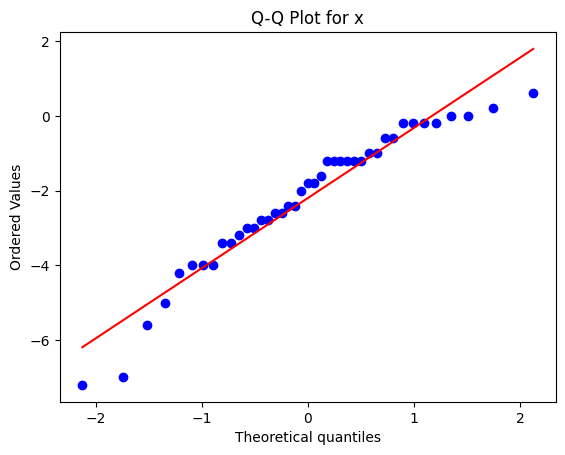

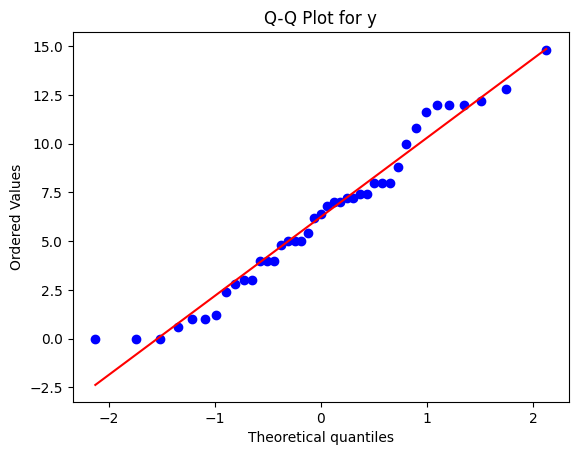

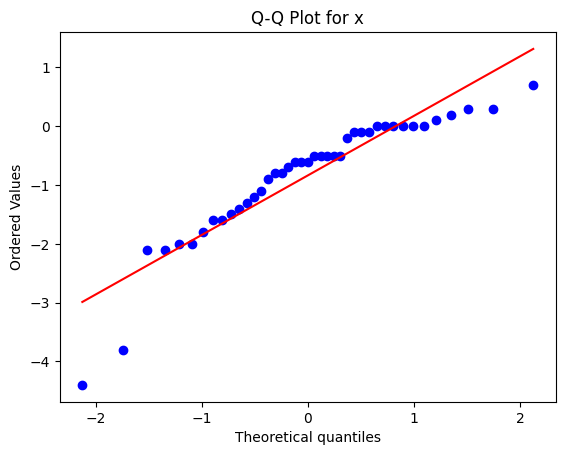

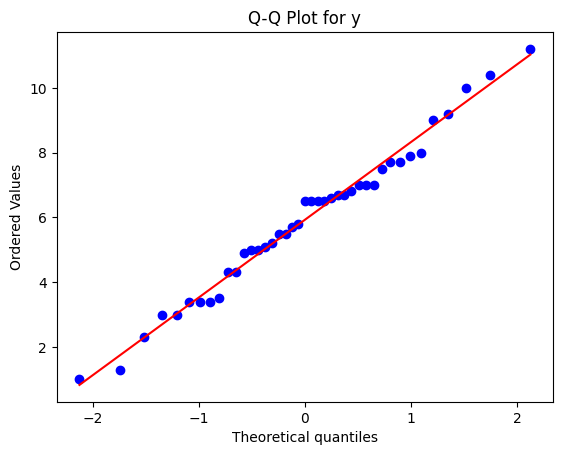

In [28]:
stats.probplot(diff_2a, dist="norm", plot=plt)
plt.title("Q-Q Plot for x")
plt.show()

stats.probplot(no_ptm_ppse_not_smooth, dist="norm", plot=plt)
plt.title("Q-Q Plot for y")
plt.show()


stats.probplot(diff_2b, dist="norm", plot=plt)
plt.title("Q-Q Plot for x")
plt.show()

stats.probplot(no_ptm_ppse_area_not_smooth, dist="norm", plot=plt)
plt.title("Q-Q Plot for y")
plt.show()

In [29]:
def test_corr(l1, l2):
    corr, p_value = pearsonr(l1, l2)
 
    print(f"Pearson's r: {corr:.3f}, R^2 {corr**2}")
    print(f"p-value: {p_value:.5f}")
    return corr, p_value


comp_paris = [
    (diff_2a, no_ptm_ppse_not_smooth),
    (diff_2b, no_ptm_ppse_area_not_smooth),
]

p_value_list = []
corrs = []
for elem in comp_paris:
    corr, p_val = test_corr(elem[0], elem[1])
    corrs.append(corr)
    p_value_list.append(p_val)

rejected, pvals_corrected, _, _ = multipletests(p_value_list, alpha=0.05, method='fdr_bh')

print("Rejected hypotheses:", rejected)
print("Adjusted p-values:", pvals_corrected)


Pearson's r: -0.638, R^2 0.4075053207969246
p-value: 0.00001
Pearson's r: -0.088, R^2 0.007656457938581353
p-value: 0.58644
Rejected hypotheses: [ True False]
Adjusted p-values: [1.42119729e-05 5.86441922e-01]


In [31]:
# Create overview plots 

def print_box_plot_stats(name, values):
    median = np.median(values)
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower_whisker = np.min(values[values >= q1 - 1.5 * iqr])
    upper_whisker = np.max(values[values <= q3 + 1.5 * iqr])
    min_val = np.min(values)
    max_val = np.max(values)

    print(f"Boxplot for {name}:")
    print(f"  Count: {len(values)}")
    print(f"  Median: {median:.4f}")
    print(f"  Q1 (25th percentile): {q1:.4f}")
    print(f"  Q3 (75th percentile): {q3:.4f}")
    print(f"  IQR: {iqr:.4f}")
    print(f"  Lower Whisker: {lower_whisker:.4f}")
    print(f"  Upper Whisker: {upper_whisker:.4f}")
    print(f"  Min: {min_val:.4f}")
    print(f"  Max: {max_val:.4f}")
    print("")


#### PLOT 1: Accessibility change of AA with PTM compared to surrounding 


fig = make_subplots(rows=1, cols=2, subplot_titles=('', ''))
fig.add_trace(go.Box(y=diff_1, name='B1)', marker_color='black'), row=1, col=1)
fig.add_trace(go.Box(y=diff_2, name='B2)', marker_color='black'), row=1, col=2)
fig.update_layout(
    title_text='',
    font=dict(size=24), 
    height=600, 
    width=700,
    showlegend=False 
)
fig.update_yaxes(title_text='pPSE Difference', row=1, col=1, matches='y')
fig.update_yaxes(title_text='', row=1, col=2, matches='y')

fig.show()

print_box_plot_stats("B1", diff_1)
print_box_plot_stats("B2", diff_2)


#### PLOT 2: Accessibility change of AA or Area with PTM compared to without PTM 


fig = make_subplots(rows=1, cols=2, subplot_titles=('', ''))

fig.add_trace(go.Box(y=diff_2a, name='PTM pPSE Change', marker_color='black'), row=1, col=1)
fig.add_trace(go.Box(y=diff_2b, name='Area pPSE Change', marker_color='black'), row=1, col=2)

fig.update_layout(
    title_text='',
    font=dict(size=24), 
    height=600,
    width=700,
    showlegend=False 
)
fig.update_yaxes(title_text='pPSE Difference', row=1, col=1, matches='y')
fig.update_yaxes(title_text='', row=1, col=2, matches='y')
fig.show()
print_box_plot_stats("PTM pPSE Change", diff_2a)
print_box_plot_stats("Area pPSE Change", diff_2b)

#### PLOT 3: Accessibility change of AA with PTM for pPSE value of structure without PTM at the position of the PTM 
data = {
    'ptm_ppse_change': diff_2a,
    'area_ppse_change': diff_2b,
    'me': me_ppse,
    'ptm_ppse_not_smooth': ptm_ppse_not_smooth,
    'ptm_ppse_smooth': ptm_ppse_smooth,
    'no_ptm_ppse_not_smooth': no_ptm_ppse_not_smooth
}
df = pd.DataFrame(data)
df_melted = df.melt(id_vars=['ptm_ppse_change', 'area_ppse_change'],
                    value_vars=['no_ptm_ppse_not_smooth'],
                    var_name='Metric',
                    value_name='Value')

fig = px.scatter(
    df_melted, 
    x="Value",
    y="ptm_ppse_change",
    color="Metric",
    trendline="ols",
    title="",
    labels={
        "ptm_ppse_change": "PTM pPSE Change",
        "Value": "original pPSE Value at PTM",
        "Metric": "PTM PPSE Type" 
    },
    color_discrete_map={ 
        "no_ptm_ppse_not_smooth": "black",
    },
    hover_data={'ptm_ppse_change': True, 'Value': True, 'Metric': True} 
)

fig.update_layout(
    xaxis_title_font_size=24,
    yaxis_title_font_size=24,
    title_font_size=18,
    hovermode="closest", 
    font=dict(size=24),
    showlegend=False,
    width=1000, 
)
fig.update_yaxes(range=[-8, 1])
fig.show()

#### PLOT 4: Accessibility change of area around the PTM for pPSE value of structure without PTM at area around  PTM 
data = {
    'ptm_ppse_change': diff_2a,
    'area_ppse_change': diff_2b,
    'me': me_ppse,
    'ptm_ppse_not_smooth': ptm_ppse_not_smooth,
    'ptm_ppse_smooth': ptm_ppse_smooth,
    'no_ptm_ppse_area_not_smooth': no_ptm_ppse_area_not_smooth
}
df = pd.DataFrame(data)
df_melted = df.melt(id_vars=['ptm_ppse_change', 'area_ppse_change'],
                    value_vars=['no_ptm_ppse_area_not_smooth'],
                    var_name='Metric',
                    value_name='Value')

fig = px.scatter(
    df_melted, 
    x="Value",
    y="area_ppse_change",
    color="Metric",
    trendline="ols",
    title="",
    labels={
        "area_ppse_change": "Area pPSE Change",
        "Value": "original pPSE Value of Area around PTM",
        "Metric": "PTM PPSE Type" 
    },
    color_discrete_map={ 
        "no_ptm_ppse_area_not_smooth": "black",
    },
    hover_data={'area_ppse_change': True, 'Value': True, 'Metric': True} 
)

fig.update_layout(
    xaxis_title_font_size=24,
    yaxis_title_font_size=24,
    title_font_size=18,
    hovermode="closest", 
    font=dict(size=24),
    showlegend=False,
    width=1000, 
)
fig.update_yaxes(range=[-8, 1])
fig.show()

Boxplot for B1:
  Count: 41
  Median: -1.4000
  Q1 (25th percentile): -2.2000
  Q3 (75th percentile): -0.1000
  IQR: 2.1000
  Lower Whisker: -4.0000
  Upper Whisker: 2.6000
  Min: -7.0000
  Max: 5.3000

Boxplot for B2:
  Count: 41
  Median: 0.1000
  Q1 (25th percentile): -1.0762
  Q3 (75th percentile): 0.8048
  IQR: 1.8810
  Lower Whisker: -2.9143
  Upper Whisker: 2.4143
  Min: -2.9143
  Max: 2.4143



Boxplot for PTM pPSE Change:
  Count: 41
  Median: -1.8000
  Q1 (25th percentile): -3.2000
  Q3 (75th percentile): -1.0000
  IQR: 2.2000
  Lower Whisker: -5.6000
  Upper Whisker: 0.6000
  Min: -7.2000
  Max: 0.6000

Boxplot for Area pPSE Change:
  Count: 41
  Median: -0.6000
  Q1 (25th percentile): -1.4000
  Q3 (75th percentile): 0.0000
  IQR: 1.4000
  Lower Whisker: -2.1000
  Upper Whisker: 0.7000
  Min: -4.4000
  Max: 0.7000



## Investigate ROG

Boxplot for rog_diff:
  Count: 41
  Median: 0.0214
  Q1 (25th percentile): -0.3437
  Q3 (75th percentile): 0.3807
  IQR: 0.7243
  Lower Whisker: -1.2338
  Upper Whisker: 1.2843
  Min: -5.2273
  Max: 4.0592

Pearson's r: 0.816, R^2 0.6660987766251011
p-value: 0.00000


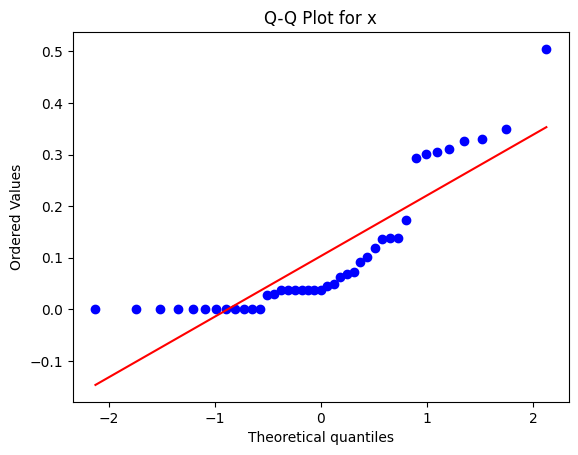

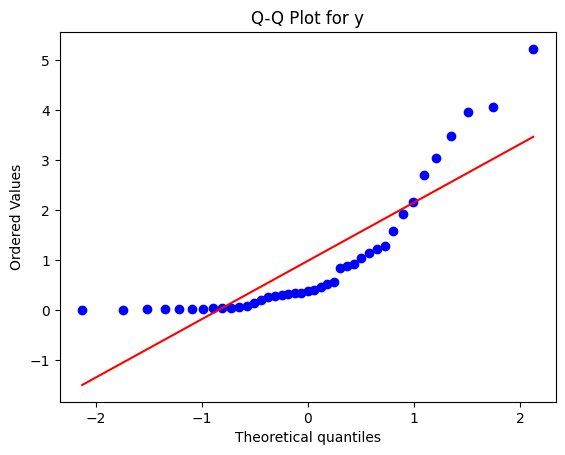

In [32]:
print_box_plot_stats("rog_diff", np.array(rog_diff))

rog_diff_abs = np.abs(np.array(rog_diff))
test_corr(rog_diff_abs, idr_perc)

stats.probplot(idr_perc, dist="norm", plot=plt)
plt.title("Q-Q Plot for x")
plt.show()

stats.probplot(rog_diff_abs, dist="norm", plot=plt)
plt.title("Q-Q Plot for y")
plt.show()

In [34]:
fig = go.Figure()

fig.add_trace(go.Box(
    y=rog_diff,
    x=[""] * len(rog_diff),
    boxpoints='outliers',
    marker_color='black',
    line_color='black'
))

fig.update_layout(
    title='',
    yaxis_title='ROG Difference',
    font=dict(size=24),
    width=350, 
    height=600
)

fig.show()


data = {
    'rog_change': rog_diff,
    'idr_perc': idr_perc
}
df = pd.DataFrame(data)
df_melted = df.melt(id_vars=['rog_change'],
                    value_vars=['idr_perc'],
                    var_name='Metric',
                    value_name='Value')

fig = px.scatter(
    df_melted, 
    x="Value",
    y="rog_change",
    color="Metric",
    title="",
    labels={
        "rog_change": "ROG Difference",
        "Value": "IDR Percentage of Protein",
        "Metric": "PTM PPSE Type" 
    },
    color_discrete_map={ 
        "no_ptm_ppse_not_smooth": "black",
        "idr_perc": "black"
    },
    hover_data={'rog_change': True, 'Value': True, 'Metric': True} 
)

fig.update_layout(
    xaxis_title_font_size=24,
    yaxis_title_font_size=24,
    title_font_size=18,
    hovermode="closest", 
    font=dict(size=24),
    showlegend=False,
    width=1000, 
)
fig.show()

## Comparison list creation

In [38]:
def create_comparison_list(df_structure_ptms, comparisons, group_avg_not_smoothed_dict, group_avg_smoothed_dict, raw_ppse_name="nAA_12_70_pae",smooth_ppse_name = "nAA_12_70_pae_smooth10"):
    comp_pairs = []
    for comparison in tqdm(comparisons):
        mod_id = comparison[0]

        transcript_id = mod_id.split("_")[0].strip()
        aa = mod_id.split("_")[2].strip()
        pos = mod_id.split("_")[3].strip()

        rows = df_structure_ptms.loc[
            (df_structure_ptms['protein_id'] == transcript_id) & 
            (df_structure_ptms['AA'] == aa) & 
            (df_structure_ptms['position'] == int(pos))
        ]
        if rows.shape[0] > 1: 
            raise ValueError("doublicate ptm")
        
        df_protein = df_structure_ptms[df_structure_ptms["protein_id"] == comparison[1]]
        
        comp_pairs.append({
            "ppse_bin": round(group_avg_smoothed_dict[comparison[1]][int(pos)]),
            "ppse": group_avg_smoothed_dict[comparison[1]][int(pos)],
            "ppse_raw": group_avg_not_smoothed_dict[comparison[1]][int(pos)],
            "pos": pos,
            "info": f"CRC: {rows.iloc[0]['TRG_ac']}, CTR: {rows.iloc[0]['CTG_ac']}",
            "idr": df_protein["IDR"].values,
            "comparison": comparison,
            "af3_mod": group_avg_smoothed_dict[comparison[0]],
            "af3_no_mod": group_avg_smoothed_dict[comparison[1]],
            "af2_no_mod": df_protein[smooth_ppse_name].values,
            "diff_af3_af2": (group_avg_smoothed_dict[comparison[1]] - df_protein[smooth_ppse_name].values),
            "diff_af3_af3_mod": (group_avg_smoothed_dict[comparison[1]] - group_avg_smoothed_dict[comparison[0]]),
        })
    return comp_pairs

In [44]:
comparison_list = create_comparison_list(df_structure_ptms, comparisons, group_avg_not_smoothed_dict, group_avg_smoothed_dict, raw_ppse_name="nAA_12_70_pae", smooth_ppse_name = "nAA_12_70_pae_smooth10")

100%|██████████| 41/41 [00:20<00:00,  2.01it/s]


In [46]:
def plot_ppse_comparison_with_differences(comp_pair, comparison_labels=None, add_vertical_line=None, safe_to_file=False, file_path=None):
    """
    Plots PPSE comparisons and their differences using subplots,
    including an IDR indicator bar between plots.

    Parameters:
        comp_pair (dict): Must contain keys: 'af3_mod', 'af3_no_mod', 'af2_no_mod', 'IDR', 'comparison', 'ppse', 'info'
        comparison_labels (list of str): Optional custom labels for the three lines.
        add_vertical_line (bool): Optional, adds vertical marker at comp_pair["pos"] if True.
        safe_to_file (bool): Whether to save to file or show interactively.
        file_path (str): Path prefix for saving image if safe_to_file is True.
    """
    ppse_cutoff = 6
    af3_mod = comp_pair["af3_mod"]
    af3_no_mod = comp_pair["af3_no_mod"]
    af2_no_mod = comp_pair["af2_no_mod"]

    mae_af2 = structural_comparison_analysis.mae(af3_no_mod, af2_no_mod, round_res=True)
    mae_mod = structural_comparison_analysis.mae(af3_no_mod, af3_mod, round_res=True)
    me_af2 = structural_comparison_analysis.mean_error(af3_no_mod, af2_no_mod, round_res=True)
    me_mod = structural_comparison_analysis.mean_error(af3_no_mod, af3_mod, round_res=True)

    x = list(range(len(af3_mod)))
    labels = comparison_labels or ['AF3 (mod)', 'AF3 (no mod)', 'AF2 (no mod)']
    color_map = {'AF3 (mod)': '#C800FF', 'AF3 (no mod)': '#00ff26 ', 'AF2 (no mod)': '#078f1c'}

    # Subplots with 3 rows (Top: pPSE, Middle: IDR, Bottom: Differences)
    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        row_heights=[0.45, 0.05, 0.45],
        vertical_spacing=0.05,
        subplot_titles=("Smoothed pPSE Comparison", "", "Difference Plot")
    )
    for annotation in fig['layout']['annotations']:
        annotation['font'] = dict(size=24) 

    # Top Plot: pPSE Values
    for label, y_vals in zip(labels, [af3_mod, af3_no_mod, af2_no_mod]):
        fig.add_trace(go.Scatter(
            x=x,
            y=y_vals,
            mode='lines+markers',
            name=label,
            line=dict(color=color_map[label])
        ), row=1, col=1)

    if add_vertical_line and "pos" in comp_pair:
        fig.add_shape(
            type='line',
            x0=comp_pair["pos"], x1=comp_pair["pos"],
            y0=min(min(af3_mod), min(af3_no_mod), min(af2_no_mod)),
            y1=max(max(af3_mod), max(af3_no_mod), max(af2_no_mod)),
            line=dict(color="black", dash='dot'),
            xref='x', yref='y',
            row=1, col=1
        )

    # pPSE cutoff line
    if any([max(af3_mod) > ppse_cutoff, max(af3_no_mod) > ppse_cutoff, max(af2_no_mod) > ppse_cutoff]):
        fig.add_shape(
            type='line',
            x0=min(x),
            x1=max(x),
            y0=ppse_cutoff,
            y1=ppse_cutoff,
            line=dict(color="red", dash='dash'),
            xref='x', yref='y',
            row=1, col=1
        )

    # Middle Plot: IDRs
    idr_array = comp_pair["idr"]
    start = None
    for i in range(len(idr_array) + 1):
        if i < len(idr_array) and idr_array[i] == 1:
            if start is None:
                start = i
        else:
            if start is not None:
                end = i - 1
                fig.add_trace(go.Scatter(
                    x=[start, end+1, end+1, start],
                    y=[0, 0, 1, 1],
                    fill='toself',
                    mode='lines',
                    line=dict(width=0),
                    fillcolor='lightblue',
                    hoverinfo='skip',
                    showlegend=False
                ), row=2, col=1)
                start = None


    fig.add_annotation(
        text="IDRs",
        xref="paper", yref="paper",
        x=-0.05, y=0.5, 
        showarrow=False,
        font=dict(size=24),
        textangle=0 
    )

    fig.update_yaxes(visible=False, row=2, col=1, range=[0, 1])
    fig.update_xaxes(visible=False, row=2, col=1)

    # Bottom Plot: Differences 
    diff_af3_af2 = [a - b for a, b in zip(af3_no_mod, af2_no_mod)]
    diff_af3_af3 = [a - b for a, b in zip(af3_no_mod, af3_mod)]

    if add_vertical_line and "pos" in comp_pair:
        fig.add_shape(
            type='line',
            x0=comp_pair["pos"], x1=comp_pair["pos"],
            y0=min(min(diff_af3_af2), min(diff_af3_af3)),
            y1=max(max(diff_af3_af2), max(diff_af3_af3)),
            line=dict(color="black", dash='dot'),
            xref='x', yref='y',
            row=3, col=1
        )

    fig.add_trace(go.Scatter(
        x=x,
        y=diff_af3_af2,
        mode='lines+markers',
        name='AF3 (no mod) - AF2',
        line=dict(color='#92ffa2')
    ), row=3, col=1)

    fig.add_trace(go.Scatter(
        x=x,
        y=diff_af3_af3,
        mode='lines+markers',
        name='AF3 (no mod) - AF3 (mod)',
        line=dict(color='#de69ff')
    ), row=3, col=1)

    # Annotation box with error metrics
    fig.add_annotation(
        text=f"Errors: <br> ME Af3/Af2: {me_af2} <br> ME Af3/Af3 with Mod: {me_mod} <br> MAE Af3/Af2: {mae_af2} <br> MAE Af3/Af3 with Mod: {mae_mod}",
        xref="paper", 
        yref="paper",
        x=1.42,  
        y=0, 
        showarrow=False,
        align="left",
        font=dict(size=24),
        bordercolor="black",
        borderwidth=1,
        bgcolor="white",
        opacity=0.8,
    )

    # Layout updates
    fig.update_layout(
        height=800,
        margin=dict(t=180), 
        title_text=f"PTM (Ac) at {comp_pair['pos']}, {comp_pair['info']} <br> with raw pPSE: {comp_pair['ppse_raw']} and smoothed pPSE: {round(comp_pair['ppse'],2)} ", # pPSE Comparison and Differences <br><span style='font-size:12px; color:gray;'> for 
        template='plotly_white',
        font=dict(
            size=24, 
        )
    )

    fig.update_xaxes(title_text='Index', row=3, col=1)
    fig.update_yaxes(title_text='Smoothed pPSE', row=1, col=1)
    fig.update_yaxes(title_text='Difference', row=3, col=1)

    config = {
        'toImageButtonOptions': {
            'format': 'png',
            'filename': f"pPSE_comp_{int(comp_pair['ppse_bin'])}_{comp_pair['comparison'][0]}"
        }
    }
    if not safe_to_file:
        fig.show(config=config)
    else:
        fig.write_image(f"{file_path}pPSE_comp_{int(comp_pair['ppse_bin'])}_{comp_pair['comparison'][0]}.png", width=1200, height=800)

In [ ]:
for elem in comparison_list:
    plot_ppse_comparison_with_differences(elem, comparison_labels=None, add_vertical_line=True, safe_to_file = True, file_path = "data/structural_comparison/images/")

/home/max/ma_thesis/code/ma_thesis/venv/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/home/max/ma_thesis/code/ma_thesis/venv/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/home/max/ma_thesis/code/ma_thesis/venv/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/home/max/ma_thesis/code/ma_thesis/venv/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/home/max/ma_the

## Old 

In [ ]:
def load_structure(file_path, structure_id):
    parser = MMCIFParser(QUIET=True)
    return parser.get_structure(structure_id, file_path)

def extract_ca_atoms_and_coords(structure):
    ca_atoms = []
    ca_coords = []
    residues = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    atom = residue['CA']
                    ca_atoms.append(atom)
                    ca_coords.append(atom.get_coord())
                    residues.append(residue.get_id())
        break
    return ca_atoms, np.array(ca_coords), residues

def compare_coords(coords1, coords2):
    return np.linalg.norm(coords1 - coords2, axis=1)  # Per-residue RMSD


def extract_ca_cb_vectors(structure):
    ca_cb_vectors = []
    valid_residues = []
    residue_count = 0
    for model in structure:
        for chain in model:
            for residue in chain:
                if is_aa(residue, standard=True) and 'CA' in residue and 'CB' in residue:
                    residue_count += 1
                    ca = residue['CA'].get_coord()
                    cb = residue['CB'].get_coord()
                    vector = cb - ca
                    norm = np.linalg.norm(vector)
                    if norm != 0:
                        ca_cb_vectors.append(vector / norm)  
                        valid_residues.append(residue_count)
            break 
        break
    return np.array(ca_cb_vectors), valid_residues


def align_structures(atoms1, atoms2, structure2):
    min_len = min(len(atoms1), len(atoms2))
    sup = Superimposer()
    sup.set_atoms(atoms1[:min_len], atoms2[:min_len])
    sup.apply(structure2.get_atoms()) 

    coords2_aligned = np.array([atom.get_coord() for atom in atoms2[:min_len]])

    if len(atoms1) == len(atoms2):
        print(f"Full match: {len(atoms1)} Cα atoms aligned.")
    else:
        print(f"Partial match: {min_len} out of {len(atoms1)} (structure1) and {len(atoms2)} (structure2) Cα atoms aligned.")

    return min_len, coords2_aligned

def compute_distances(coords1, coords2_aligned, min_len):
    distance_matrix1 = cdist(coords1[:min_len], coords1[:min_len])
    distance_matrix2 = cdist(coords2_aligned, coords2_aligned)
    difference_matrix = distance_matrix1 - distance_matrix2

    return distance_matrix1, distance_matrix2, difference_matrix

def plot_distances(structure1, structure2, distance_matrix1, distance_matrix2, difference_matrix):
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(f"Distance Matrix: {structure1.id}", f"Distance Matrix: {structure2.id}"),
        horizontal_spacing=0.05
    )

    fig.add_trace(go.Heatmap(
        z=distance_matrix1,
        colorscale='Viridis',
        colorbar=dict(title="Å"),
        showscale=True
    ), row=1, col=1)

    fig.add_trace(go.Heatmap(
        z=distance_matrix2,
        colorscale='Viridis',
        colorbar=dict(title="Å"),
        showscale=False  
    ), row=1, col=2)

    fig.update_layout(
        title_text="Pairwise Cα Distance Matrices",
        width=1200,
        height=500
    )

    fig.show()


    fig = px.imshow(
        difference_matrix,
        labels=dict(x="Residue Index", y="Residue Index", color="Distance Δ (Å)"),
        color_continuous_scale='Viridis',
        title=f"Difference in Pairwise Cα Distances for <br> {structure1.id} - {structure2.id}",
        origin='lower'
    )
    fig.update_layout(width=600, height=600)
    fig.update_yaxes(autorange="reversed")
    fig.show()

def compute_consecutive_distance(coords):
    return np.linalg.norm(coords[1:] - coords[:-1], axis=1)

def compute_consecutive_distances(coords1, coords2_aligned, min_len):
    distances1 = compute_consecutive_distance(coords1[:min_len])
    distances2 = compute_consecutive_distance(coords2_aligned)

    return distances1, distances2

def plot_consecutive_distances(structure1, structure2, distances1, distances2, min_len):
    residue_indices = np.arange(1, min_len) 

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=residue_indices,
        y=distances1,
        mode='lines+markers',
        name=f'{structure1.id}',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=residue_indices,
        y=distances2,
        mode='lines+markers',
        name=f'{structure2.id} (Aligned)',
        line=dict(color='red')
    ))

    fig.update_layout(
        title=f'Distance Between Consecutive Cα Atoms for <br> {structure1.id} and {structure2.id}',
        xaxis_title='Residue Index (i)',
        yaxis_title='Distance between Residue i and i+1 (Å)',
        legend=dict(x=0.01, y=0.99),
        width=1000,
        height=500
    )

    fig.show()


def get_vector_angles(vec1, vec2):
    cos_sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    cos_sim = np.clip(cos_sim, -1.0, 1.0)
    angle_rad = np.arccos(cos_sim)
    angle_deg = np.degrees(angle_rad)

    return angle_deg, angle_rad


def compute_vectors(structure1, structure2):
    vectors1, resids1 = extract_ca_cb_vectors(structure1)
    vectors2, resids2 = extract_ca_cb_vectors(structure2)
    common_residues = sorted(set(resids1) & set(resids2))

    vecs1_matched, vecs2_matched = [], []
    for resid in common_residues:
        vecs1_matched.append(vectors1[resids1.index(resid)])
        vecs2_matched.append(vectors2[resids2.index(resid)])
    vecs1_matched = np.array(vecs1_matched)
    vecs2_matched = np.array(vecs2_matched)

    def vector_angles(vectors, axis=np.array([0, 0, 1])):
        dots = np.dot(vectors, axis)
        dots = np.clip(dots, -1.0, 1.0)
        return np.arccos(dots) * (180 / np.pi)

    angles1 = vector_angles(vecs1_matched)
    angles2 = vector_angles(vecs2_matched)

    angle_diff = []
    for i in range(len(vecs1_matched)):
        angle_diff.append(get_vector_angles(vecs1_matched[i], vecs2_matched[i])[0])

    return angles1, angles2, angle_diff


def plot_orientation_vectors(structure1, structure2, angles1, angles2, angle_diff):
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=[
            "Cα→Cβ Orientation Angles (Z-Axis Projection)",
            "Angle Difference Between Matched Vectors"
        ]
    )

    fig.add_trace(go.Scatter(
        x=np.arange(len(angles1)), y=angles1,
        mode='lines+markers',
        name=f'{structure1.id}',
        line=dict(color='blue')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=np.arange(len(angles2)), y=angles2,
        mode='lines+markers',
        name=f'{structure2.id}',
        line=dict(color='orange')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=np.arange(len(angle_diff)), y=angle_diff,
        mode='lines+markers',
        name='Angle Difference',
        line=dict(color='green')
    ), row=2, col=1)

    fig.update_layout(
        height=700, width=1300,
        title="Comparison of Cα→Cβ Vector Orientations",
        xaxis_title="Matched Residue Index",
        yaxis_title="Angle (degrees)",
        showlegend=True
    )
    fig.update_yaxes(title_text="Angle (°)", row=1, col=1)
    fig.update_yaxes(title_text="Angle Difference (°)", row=2, col=1)

    fig.show()


In [50]:
structure1 = load_structure("data/af3_validation/org_cif/mod/2giv.cif", "2GIV (experimental)")
structure2 = load_structure("data/af3_validation/cif/2GIV_ac_K_98_m0.cif", "2GIV (pred mod)")


atoms1, coords1, residues1 = extract_ca_atoms_and_coords(structure1)
atoms2, coords2, residues2 = extract_ca_atoms_and_coords(structure2)

min_len, coords2_aligned = align_structures(atoms1, atoms2, structure2)

def compute_rmsd_aligned(coords1, coords2_aligned, min_len):
    diff = coords1[:min_len] - coords2_aligned
    rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
    return rmsd

rmsd = compute_rmsd_aligned(coords1, coords2_aligned, min_len)
print(f"RMSD after alignment: {rmsd:.3f} Å")


Full match: 258 Cα atoms aligned.
RMSD after alignment: 1.323 Å


In [51]:
distance_matrix1, distance_matrix2, difference_matrix = compute_distances(coords1, coords2_aligned, min_len)

plot_distances(structure1, structure2, distance_matrix1, distance_matrix2, difference_matrix)

In [52]:
distances1, distances2 = compute_consecutive_distances(coords1, coords2_aligned, min_len)

print(f"Distances 1: {sum(distances1)}")
print(f"Distances 2: {sum(distances2)}")

plot_consecutive_distances(structure1, structure2, distances1, distances2, min_len)

Distances 1: 993.6988704204559
Distances 2: 977.0133628845215


In [54]:
angles1, angles2, angle_diff = compute_vectors(structure1, structure2)
plot_orientation_vectors(structure1, structure2, angles1, angles2, angle_diff)
